## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv(r'C:\Users\ASUS\OneDrive\Courses\Business Analytics\Data Analyst Nanodegree\Part03PracticalStatistics\Project03\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
print('the proportion of users converted: {:.2%}'.format(df[df['converted'] == 1].shape[0]/df.shape[0]))

the proportion of users converted: 11.97%


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').index)
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [11]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2 = df2.drop_duplicates(['user_id'])
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
print('any individual has an {:.2%} propability of conversion'.format(df2[df2['converted'] == 1].shape[0]/df2.shape[0]))

any individual has an 11.96% propability of conversion


b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
print('an individual in the control group has a {:.2%} propability of conversion'.format(df2.query('group == "control" and converted == 1').shape[0]/df2[df2['group'] == 'control'].shape[0]))

an individual in the control group has a 12.04% propability of conversion


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
print('an individual in the treatment group has an {:.2%} propability of conversion'.format(df2.query('group == "treatment" and converted == 1').shape[0]/df2[df2['group'] == 'treatment'].shape[0]))

an individual in the treatment group has an 11.88% propability of conversion


d. What is the probability that an individual received the new page?

In [16]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

results show that both conversion rates for the treatment and control groups are near to each other (very close to 12%). This and having a 50% probability of landing a new page help us conclude that there is not enough evidence that the new treatment page leads to more conversions

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [17]:
p_new = df2[df2['converted'] == 1].shape[0]/df2.shape[0]

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [18]:
p_old = df2[df2['converted'] == 1].shape[0]/df2.shape[0]

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
N_new = df2.query('group == "treatment" and landing_page == "new_page"')['user_id'].nunique()
N_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
N_old = df2.query('group == "control" and landing_page == "old_page"')['user_id'].nunique()
N_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.binomial(1, p_new, N_new)
new_page_converted.mean()

0.11745922510494804

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.binomial(1, p_old, N_old)
old_page_converted.mean()

0.11936753995897408

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

-0.0019083148540260386

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(1, p_old, N_old)
    old = old_page_converted.mean()
    new_page_converted = np.random.binomial(1, p_new, N_new)
    new = new_page_converted.mean()
    p_diffs.append(new - old)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

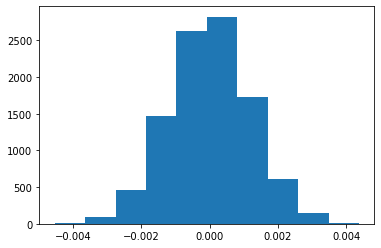

In [25]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
cont = df2.query('group == "control"')['converted'].mean()
treat = df2.query('group == "treatment"')['converted'].mean()
diff = treat - cont
diff

-0.0015782389853555567

In [27]:
pvalue = (np.array(p_diffs) > diff).mean()
pvalue

0.9112

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The computed pvalue shows nearly 90% of our simulated difference values are away from our observed difference of our dataset.

That is, our observation here shows that we are far away from the type 1 error (alpha = 0.05%) and that at any given point we will fail to reject the null hypothesis.

Therefore we will accept the null hypothesis stated before: $$H_0: p_{new} - p_{old} <= 0$$

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [30]:
import scipy.stats as stats
import math

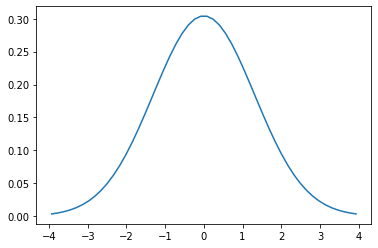

In [31]:
x = np.linspace(0 - 3*z_score, 0 + 3*z_score)
plt.plot(x, stats.norm.pdf(x, 0, z_score));
plt.show();

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Still the results lead to the same conclusion, now the p_value computed is not different from the one computed in j. That is our data result is far away from the observed difference, and we will still fail to reject the null.

The statistics here show an additional evidence with the z-score (standard deviation), now that it is positive we can deduce that at any given sampling, an individual result will drift far away from the mean and that our values tend to be extreme

I used the following link(s) to support my answer

https://www.answers.com/Q/What_does_the_z_score_of_1.3_mean
http://statistics-help-for-students.com/How_do_I_interpret_Z_score_data_in_SPSS.htm#.XfSmYWQzY2w

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression model that should be performed is the logistic regression model.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
#get the dummies
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [34]:
#associate with the treatment group, to have ab_page as treatment and new!!!
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        14:57:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value in my regression model returned 0.190.
In this regression model, we are measuring a null hypothesis of that there is no difference between the control group and treatment group (in terms of conversion). And that the alternative hypothesis will show a difference between both groups. In Part II, we were measuring our p-value for the null hypothesis that the old page is better that the new page under a type 1 error of 5%

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

If I would like to consider an extra factor to my model, this will be the timestamp, categorizing the timestamp will add a categorial variable in the dataset which I can add to my regression model and further predict the conversion of my A/B Test in the aspect of time (Just as the weekend and weekday categories).

The article in the link https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/ highights the main cautions and pitfalls for logistic regression models. That is, *"While it is tempting to include as many input variables as possible, this can dilute true associations and lead to large standard errors with wide and imprecise confidence intervals, or, conversely, identify spurious associations."* as stated. Also "*Overfitting the model*" as stated in the link https://www.theclassroom.com/disadvantages-logistic-regression-8574447.html can have a bad influence on the regression model due to being biased.



#### Timestamp Variabe approach

I am doing this extra part of the exercise to fit in the timestamp as a categorial variable to see how will this actually affect the model and support my answers.

Using the link https://www.ritchieng.com/pandas-date-time/ to convert timestamps
and https://stackoverflow.com/questions/32278728/convert-dataframe-date-row-to-a-weekend-not-weekend-value/32280195 to mark weekends

In [36]:
# Convert the datetime column to its rightful format, might be useful to add it in another column?
df2['timestamp'] = pd.to_datetime(df2.timestamp)
df2.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
intercept                int64
new_page                 uint8
old_page                 uint8
ab_page                  uint8
dtype: object

In [37]:
#add a column for the day and a column whether the day is weekday or weekend (as a 0,1 variable for 1 is for weekends)
df2['day']= df2.timestamp.dt.weekday_name
df2['weekend'] = ((pd.DatetimeIndex(df2.timestamp).dayofweek) // 5 == 1).astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,day,weekend
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,Saturday,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,Thursday,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,Wednesday,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,Sunday,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,Saturday,1


In [38]:
# Now I want to rerun my model with an extra variable, the weekend
log_mod = sm.Logit(df2['converted'], df2[['intercept','weekend','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 20 Dec 2019   Pseudo R-squ.:               8.088e-06
Time:                        14:57:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9889      0.009   -226.066      0.000      -2.006      -1.972
weekend        0.0006      0.013      0.049      0.961      -0.024       0.026
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [39]:
print('weekend = {}'.format(1/np.exp(-0.0006))), print('ab_page = {}'.format(1/np.exp(-0.0150)))

weekend = 1.0006001800360054
ab_page = 1.015113064615719


(None, None)

Although I exercised the addition of the weekend/weekday variable to see the effect on our model and our analysis (conversion of our treatment on weekends), I can revert to the high p-values in my output to suggest that my addition of this variable is not statistically significant at p-value of 0.961 :(

We can say that we fail to reject the null hypothesis in this case.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
#I want to import the dataframe
cnt = pd.read_csv(r'C:\Users\ASUS\OneDrive\Courses\Business Analytics\Data Analyst Nanodegree\Part03PracticalStatistics\Project03\countries.csv')
#Now I want to merge both together in a new one

In [41]:
dfn = df2.merge(cnt, on = 'user_id', how = 'left')
dfn.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,day,weekend,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,Saturday,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,Thursday,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,Wednesday,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,Sunday,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,Saturday,1,US


In [42]:
#how many countries do we have?
dfn['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [43]:
# get the dummies
dfn[['CA','UK','US']] = pd.get_dummies(dfn['country'])
dfn.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,day,weekend,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,Saturday,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,Thursday,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,Wednesday,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,Sunday,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,Saturday,1,US,0,0,1


In [51]:
#I am adding US to my baseline for the country effect
log_mod = sm.Logit(dfn['converted'], dfn[['intercept','ab_page','CA','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 20 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        14:59:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [52]:
# we will want to get the exp of our findings
print('ab_page = {}'.format(1/np.exp(-0.0149)))
print('CA = {}'.format(1/np.exp(-0.0408)))
print('UK = {}'.format(1/np.exp(-0.0099)))

ab_page = 1.0150115583846535
CA = 1.0416437559600236
UK = 1.009949167117542


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

Since the question here directly refers to the pages for interaction, I will use new_page this time.

https://stats.stackexchange.com/questions/105543/how-to-prepare-interactions-of-categorical-variables-in-scikit-learn/274108
https://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/

In [53]:
#An intercation is var1*var2 we will want to interact the new page to the countries that way
dfn['US_new_page'] = dfn['new_page']*dfn['US']
dfn['UK_new_page'] = dfn['new_page']*dfn['UK']
dfn['CA_new_page'] = dfn['new_page']*dfn['CA']
dfn.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,day,weekend,country,CA,UK,US,US_new_page,UK_new_page,CA_new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,Saturday,1,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,Thursday,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,Wednesday,0,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,Sunday,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,Saturday,1,US,0,0,1,0,0,0


In [54]:
#Now I will use the exact same model and just add my newly added columns, remember that US is a baseline here
log_mod = sm.Logit(dfn['converted'], dfn[['intercept','ab_page','UK_new_page','CA_new_page','CA','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 20 Dec 2019   Pseudo R-squ.:               3.482e-05
Time:                        15:07:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page        -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_new_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_new_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
===============================================================================
"""

Just by looking at the results, the p-values of the variables are all beyond the common 5%, leaving only the intercept as the statistically significant value. Therefore we can conclude that the country where a user lives in is not a significant variable, given that the interaction is not significant.

Finally we fail to reject the null hypothesis here stating that there is no difference between the old page and the new page

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0